# Approximating a Gunshot Waveform with ReLU Networks

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Input

## Defining the base functions

In [2]:
x_values = np.linspace(0, 1, 1000)
m = 2 # number of breakpoints (is put to the power of 2)
d = 50 # Degree for taylor series approximation

# Define the activation function (vectorized for NumPy arrays)
def relu(x):
    return np.maximum(0, x)

# "tooth" function using ReLU operations
def tooth(x):
    return relu(2 * relu(x) - 4 * relu(x - 1 / 2))

# Composition function
def g(x, s):
    if s == 0:
        return x
    return g(tooth(x), s - 1)

# Plotting the true function vs. approximation function
def plot(true_values, approx_values, x_values):
    plt.figure(figsize=(8, 6))
    plt.plot(x_values, true_values, label="true values", color="blue", linewidth=2)
    plt.plot(x_values, approx_values, label="approx values", color="red", linewidth=2)

    plt.xlabel("x")
    plt.ylabel("Function values")
    plt.title(f"Mean absolute error = {np.mean(np.abs(true_values - approx_values))}")
    plt.grid()
    plt.show()

## Approximating the square function

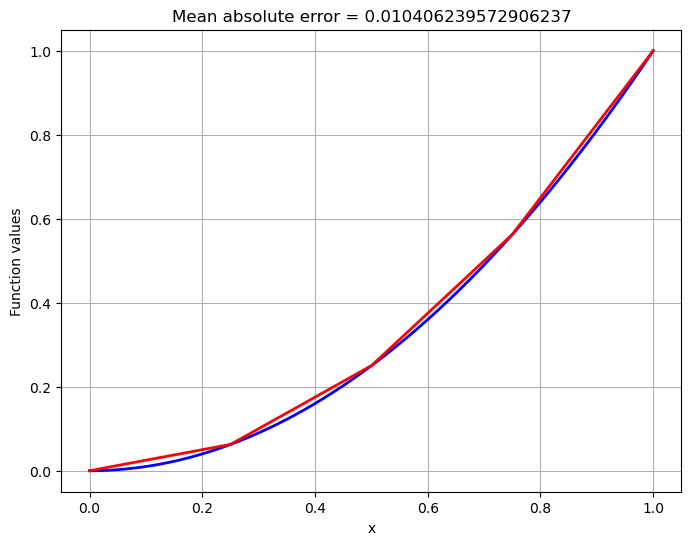

In [3]:
# Approximation function
def h_square(x, m):
    terms = np.array([g(x, s) / (2 ** (2 * s)) for s in range(1, m + 1)])
    return x - np.sum(terms, axis=0)

h_square_values = h_square(x_values, m)
square_values = np.square(x_values)
plot(square_values,h_square_values,x_values)

## Creating helpers for multiplication with square

We create a multiplying function using expansion of squared sum, with a slightly different formula to accommodate for the fact that $x+y$ must be less than 1

In [4]:
def h_mult(x,y,m):
    return (h_square((x+y)/2,m) - h_square(x/2,m) - h_square(y/2,m))*2
 
def h_power(x,m,k):
    if k == 0: 
        return 1
    if k == 1:
        return x
    return h_power(h_mult(x,x,m),m,k-1)

## Approximating the exponential function
We can also use taylor expansions in order to approximate functions. Furthermore, we also have to redefine $m$, to get a better precision given the accumulation of approximation errors

In [5]:
m = 10

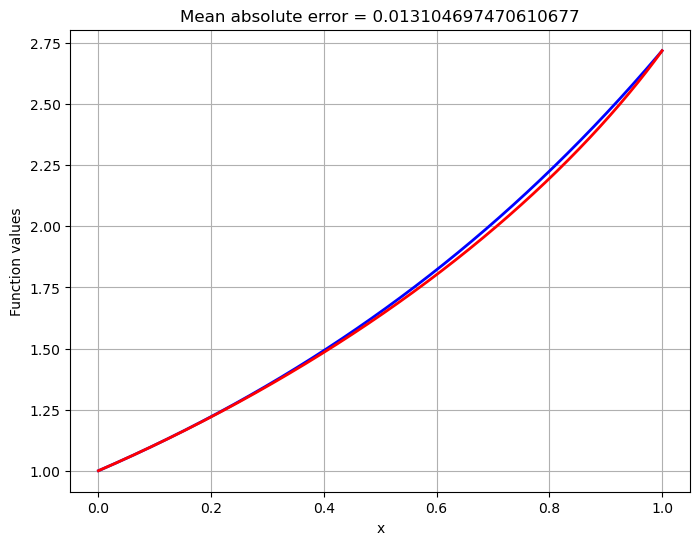

In [6]:
def h_exp(x, m, d):
    s = np.zeros_like(x)
    for i in range(d):
        s += h_mult(h_power(x,m,i),1/math.factorial(i),m)
    return s

h_exp_values = h_exp(x_values,m,d)
exp_values = np.exp(x_values)

plot(exp_values, h_exp_values, x_values)

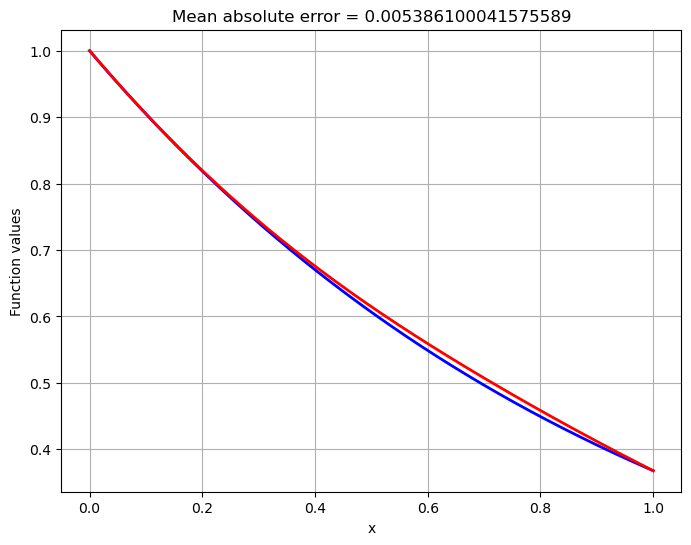

In [7]:
def h_mexp(x, m, d):
    s = np.zeros_like(x)
    for i in range(0,d,2):
        s += h_mult(h_power(x,m,i),1/math.factorial(i),m)
    for i in range(1,d,2):
        s -= h_mult(h_power(x,m,i),1/math.factorial(i),m)
    return s

h_mexp_values = h_mexp(x_values,m,d)
mexp_values = np.exp(-x_values)

plot(mexp_values, h_mexp_values,x_values)

## Approximating the sine function

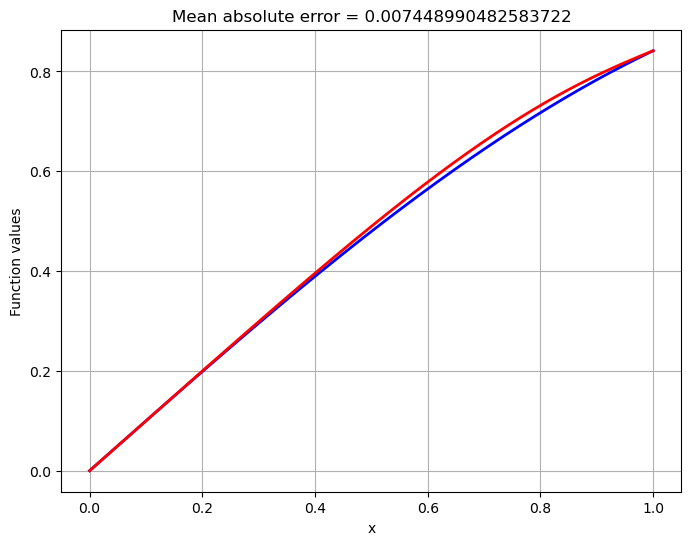

In [8]:
def h_sin(x, m, d):
    s = np.zeros_like(x)
    for i in range(1,d,4):
        s += h_mult(h_power(x,m,i),1/math.factorial(i),m)
    for i in range(3,d,4):
        s -= h_mult(h_power(x,m,i),1/math.factorial(i),m)
    return s


h_sin_values = h_sin(x_values,m,d)
sin_values = np.sin(x_values)

plot(sin_values, h_sin_values,x_values)

Since the domain of definition of `h_square` is $[0,1]$, we cannot extend this approximation of $x \rightarrow sin(x)$ to $[0;\pi]$

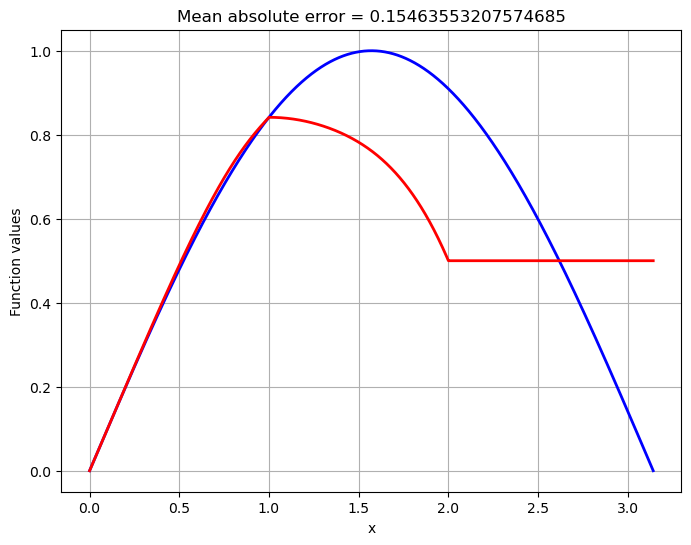

In [9]:
x_values_sin = np.linspace(0, np.pi, 3000)

h_sin_values2 = h_sin(x_values_sin,m,d)
sin_values2 = np.sin(x_values_sin)

plot(sin_values2,h_sin_values2,x_values_sin)

## Approximating $e^x \times \sin(x)$

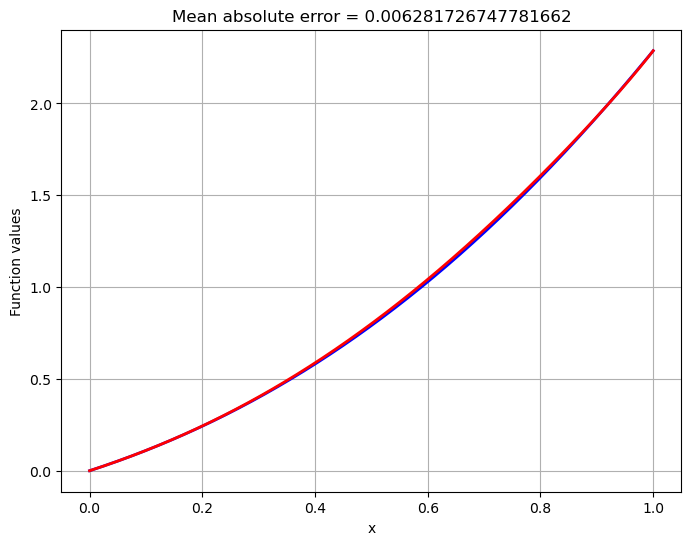

In [10]:
# We need rescaling once again for h_exp_values
plot(np.multiply(sin_values,exp_values), 3*h_mult(h_sin_values,h_exp_values/3,m),x_values)

## Approximating $e^{-x} \times \sin(x)$

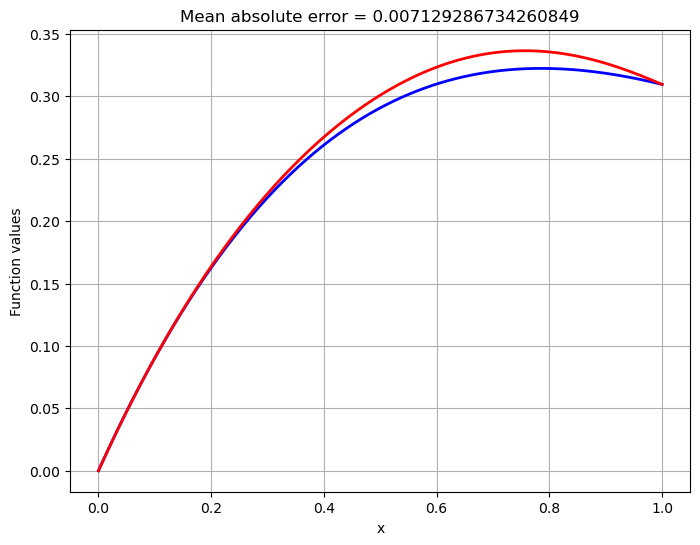

In [11]:
# We need rescaling once again for h_exp_values
plot(np.multiply(sin_values,mexp_values), 3*h_mult(h_sin_values,h_mexp_values/3,m),x_values)

## Theory Vs. Practice

Even though we have proven that our function can be approximated with a neural network of depth 6 and that we have designed a neural network capable of approximating our signal with small error, the results in practice can be very different to theoretical results. This can notably be noticed in the $n$-ap problem, for which we can also prove that it can be approximated with any error from a depth-6 network

In [12]:
# Data
X = np.array([[0],[.125],[.25],[.375],[.5],[.625],[.75],[.875]])
y = np.array([[0],[1],[0],[1],[0],[1],[0],[1]])

### Theory 

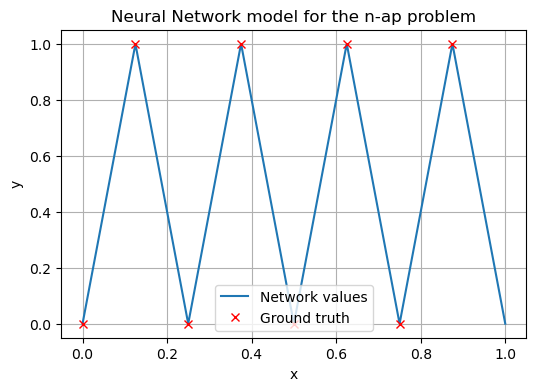

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(x_values.reshape((-1,1)),g(x_values,3),label="Network values")
plt.plot(X,y,'rx',label="Ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Neural Network model for the n-ap problem")
plt.grid()

### Practice

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5000 - loss: 8.0590

compile_metrics: 50.00%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


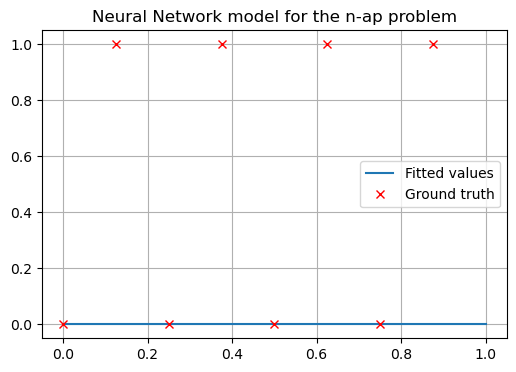

In [16]:
model = Sequential()
model.add(Input(shape=(1,)))
model.add(Dense(2, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=1000, batch_size=8,verbose=0)

scores = model.evaluate(X, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

xx = x_values.reshape((-1,1))
plt.figure(figsize=(6, 4))
plt.plot(xx,model.predict(xx),label="Fitted values")
plt.plot(X,y,'rx',label="Ground truth")
plt.title("Neural Network model for the n-ap problem")
plt.legend()
plt.grid()